In [14]:
# Step 1: Import required libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

# Step 2: Load Titanic dataset from the GitHub repository
train_url = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv'
test_url = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/test.csv'

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

# Step 3: Feature Engineering
# Create new features based on existing data
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extract titles from names
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Map common titles to reduce categories
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6, 'Col': 6, 'Major': 6,
                 'Mlle': 2, 'Countess': 6, 'Ms': 2, 'Lady': 6, 'Jonkheer': 6, 'Don': 6, 'Dona': 6, 'Mme': 3, 'Capt': 6, 'Sir': 6}
train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].map(title_mapping)

# Fill missing titles with the most common one
train_df['Title'].fillna(1, inplace=True)
test_df['Title'].fillna(1, inplace=True)

# Handle missing values, e.g., fill missing ages with the median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

# Apply same transformations to test data
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Convert categorical features into numerical ones
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'])
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'])

# Drop irrelevant columns
train_df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)
test_df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)

# Step 4: Prepare data for training
X_train = train_df.drop(columns=['Survived'])
y_train = train_df['Survived']
X_test = test_df.copy()

# Split training data for validation
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 5: Train a Random Forest model
# Use GridSearchCV to optimize hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Best parameters from grid search
best_rf = grid_search.best_estimator_

# Step 6: Validate the model
y_pred = best_rf.predict(X_valid)

# Evaluate with confusion matrix and accuracy
conf_matrix = confusion_matrix(y_valid, y_pred)
accuracy = accuracy_score(y_valid, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")

# Step 7: Make predictions on the test data
test_predictions = best_rf.predict(X_test)

# Step 8: Create a DataFrame for the submission file
submission = pd.DataFrame({
    'PassengerId': pd.read_csv(test_url)['PassengerId'],
    'Survived': test_predictions
})

# Save the submission to CSV
submission.to_csv('submission.csv', index=False)

# Print the first few rows of the submission
submission.head()


Fitting 5 folds for each of 81 candidates, totalling 405 fits


<ipython-input-14-15cef478235d>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Title'].fillna(1, inplace=True)
<ipython-input-14-15cef478235d>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

Confusion Matrix:
[[92 13]
 [21 53]]
Accuracy: 0.8101


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


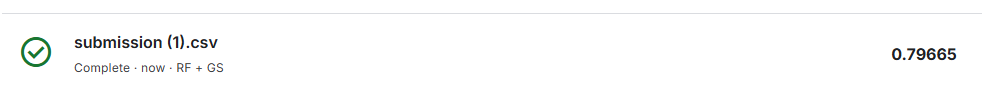